# Risk Model

## Goal 
Rank contractors by their risk level

## Strategy
1. Predict when a contractor will have a claim
    - Use all features created
    - Use Profile features from clients.csv file
    - Issue here with claims having happened in the past and contractors having activity afterwards
2. Rank contractors based on the likelihood of having a claim

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN ,BorderlineSMOTE , KMeansSMOTE , SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as imb_pipeline
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from sklearn.preprocessing import (
    # StandardScaler,
    RobustScaler
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold as vt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, precision_recall_curve,accuracy_score, matthews_corrcoef
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score, average_precision_score
import seaborn as sns
import keras
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics


In [2]:
#!pip install lightgbm

## Load Data

In [3]:
df = pd.read_csv('../data/features_merged.csv', index_col='AccountId')
print(df.shape)
# Feature columns to use
df.columns[:-1]

(3292, 98)


Index(['YearsSinceSubmission', 'YearsSinceIncorporated',
       'ContractorGroup_General Contractor',
       'ContractorGroup_Heavy Engineering',
       'ContractorGroup_Service Contractor', 'ContractorGroup_Specialty',
       'ContractorGroup_Subcontractor', 'ContractorGroup_nan', 'Province_AB',
       'Province_BC', 'Province_MB', 'Province_NB', 'Province_NL',
       'Province_NS', 'Province_ON', 'Province_Other', 'Province_QC',
       'Province_SK', 'Province_YT', 'TotalCurrentAsset', 'TotalAssets',
       'TangibleNetWorth', 'WorkingCapital', 'WorkingCapitalRatio', 'AcidTest',
       'NetQuick', 'WorkingCapitalVsOverhead', 'TotalDebtToEquity',
       'GrossProfitMargin', 'OperatingProfitMargin',
       'AnnualGrossContractIncome', 'AnnualTotalOperatingRevenue',
       'AnnualTotalDirectExpense', 'AnnualTotalOverheadExpense',
       'AnnualGrossProfit', 'AnnualOperatingProfit', 'TotalCurrentAssetTrend',
       'TotalCurrentAssetSlope', 'TotalAssetsTrend', 'TotalAssetsSlope',
       

In [58]:
df.shape 

(2762, 62)

In [5]:
contractor_df = df.loc[:,['ContractorGroup_General Contractor',
       'ContractorGroup_Heavy Engineering',
       'ContractorGroup_Service Contractor', 'ContractorGroup_Specialty',
       'ContractorGroup_Subcontractor', 'ContractorGroup_nan']]


In [6]:
province_df = df.loc[:,['Province_AB', 'Province_BC', 'Province_MB', 'Province_NB', 'Province_NL', 'Province_NS', 'Province_ON', 'Province_Other', 'Province_QC', 'Province_SK', 'Province_YT']]

In [7]:
df = df.loc[:,['YearsSinceSubmission','YearsSinceIncorporated', 'TotalCurrentAsset', 'TotalAssets','TangibleNetWorth', 'WorkingCapital', 'WorkingCapitalRatio', 'AcidTest','NetQuick', 'WorkingCapitalVsOverhead', 'TotalDebtToEquity','GrossProfitMargin', 'OperatingProfitMargin', 'AnnualGrossContractIncome', 'AnnualTotalOperatingRevenue', 'AnnualTotalDirectExpense', 'AnnualTotalOverheadExpense','AnnualGrossProfit', 'AnnualOperatingProfit', 'TotalCurrentAssetTrend', 'TotalAssetsTrend', 'TangibleNetWorthTrend', 'WorkingCapitalTrend','WorkingCapitalRatioTrend','AcidTestTrend','NetQuickTrend','WorkingCapitalVsOverheadTrend','TotalDebtToEquityTrend','GrossProfitMarginTrend','OperatingProfitMarginTrend','AnnualGrossContractIncomeTrend','AnnualTotalOperatingRevenueTrend','AnnualTotalDirectExpenseTrend','AnnualTotalOverheadExpenseTrend','AnnualGrossProfitTrend', 'AnnualOperatingProfitTrend','MaxOpenBondAmount', 'MinOpenBondAmount','MinNonZeroOpenBondAmount', 'AvgOpenBondAmount','AvgNonZeroOpenBondAmount', 'MaxOpenBondCount', 'MinOpenBondCount','MinNonZeroOpenBondCount', 'AvgOpenBondCount','AvgNonZeroOpenBondCount', 'NumberObligees','MaxObligeeMaxContractPrice', 'MaxObligeeTotalContractPrice','MeanObligeeMeanContractPrice', 'AverageDaysValid','NumberOfRevisedContracts','NumberOfRevisedContractsIncreased','NumberOfRevisedContractsDecreased', 'AvgRevisionPercentageIncreased','AvgRevisionPercentageDecreased', 'NumberOfDateRevisedContracts', 'AvgDaysRevised', 'NumberYearsWithWOH', 'NumberWOHStatements','WOHAverageProfitPct','WOHCashToCompleteHigherThanCurrentCashCount','HasProjectWithMultipleWOHIds', 'HasClaim']]

In [8]:
df.shape

(3292, 64)

In [9]:
province_df['Province']=''
for col_name in province_df:
    province_df.loc[province_df[col_name]==1,'Province']= province_df['Province']+' '+col_name


In [10]:
contractor_df['Contractor']=''
for col_name in contractor_df:
    contractor_df.loc[contractor_df[col_name]==1,'Contractor']= contractor_df['Contractor']+' '+col_name


In [11]:
contractor_df['Contractor']= contractor_df['Contractor'].str.strip()
contractor_df['Contractor'].replace(['ContractorGroup_General Contractor',
       'ContractorGroup_Heavy Engineering',
       'ContractorGroup_Service Contractor', 'ContractorGroup_Specialty',
       'ContractorGroup_Subcontractor', 'ContractorGroup_nan'], [1,2,3,4,5,6], inplace=True)


In [12]:
province_df['Province']= province_df['Province'].str.strip()
province_df['Province'].replace(['Province_AB','Province_BC','Province_MB','Province_NB','Province_NL','Province_NS','Province_ON','Province_Other','Province_QC','Province_SK','Province_YT'], [1,2,3,4,5,6,7,8,9,10,11], inplace=True)


In [13]:
df = pd.concat([province_df['Province'],contractor_df['Contractor'],df], axis=1, join="inner")
df

,Province,Contractor,YearsSinceSubmission,YearsSinceIncorporated,TotalCurrentAsset,TotalAssets,TangibleNetWorth,WorkingCapital,WorkingCapitalRatio,AcidTest,...,AvgRevisionPercentageIncreased,AvgRevisionPercentageDecreased,NumberOfDateRevisedContracts,AvgDaysRevised,NumberYearsWithWOH,NumberWOHStatements,WOHAverageProfitPct,WOHCashToCompleteHigherThanCurrentCashCount,HasProjectWithMultipleWOHIds,HasClaim
AccountId,,,,,,,,,,,,,,,,,,,,,
4708655.0,7,1,16.257692,25.054084,4.471070e+05,4.975767e+05,3.950390e+05,3.905633e+05,8.740000,3.905633e+05,...,0.000000,0.000000,1,98.000,0.0,0.0,0.000000,0.000000,0.0,0
4708657.0,7,5,16.257692,50.577356,1.092850e+06,1.328627e+06,8.351217e+05,7.532420e+05,3.490000,6.554920e+05,...,0.157790,0.000000,0,0.000,2.0,5.0,0.264840,0.400000,0.0,0
4708659.0,7,2,16.257692,25.054084,1.651797e+06,3.776497e+06,7.954333e+05,-1.469900e+05,0.913333,-2.242900e+05,...,0.000000,-14.519232,2,131.000,0.0,0.0,0.000000,0.000000,0.0,0
4708661.0,7,1,8.347761,25.054084,4.413333e+05,5.923333e+05,2.183333e+05,1.813333e+05,1.733333,8.566667e+04,...,0.000000,0.000000,0,0.000,0.0,0.0,0.000000,0.000000,0.0,0
4708663.0,7,5,16.202934,33.832317,7.634603e+06,2.103957e+07,5.524550e+06,2.173990e+05,1.033333,1.115170e+05,...,11.027221,-39.055772,8,177.625,8.0,89.0,0.160737,0.617978,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826566.0,9,4,0.194391,3.912469,5.179000e+06,7.053000e+06,3.016000e+06,2.314000e+06,1.800000,1.287000e+06,...,0.000000,0.000000,0,0.000,0.0,0.0,0.000000,0.000000,0.0,0
7830221.0,5,4,0.180702,12.123452,6.533000e+05,2.753120e+06,1.351180e+06,4.018000e+05,2.590000,4.018000e+05,...,0.000000,0.000000,0,0.000,0.0,0.0,0.000000,0.000000,0.0,0
7853049.0,7,2,0.158799,25.054084,5.516545e+05,1.635415e+06,-5.879535e+05,-7.778310e+05,0.405000,-7.901105e+05,...,0.000000,0.000000,0,0.000,0.0,0.0,0.000000,0.000000,0.0,0


In [14]:
df= df.loc[:,['Province', 'Contractor',
'YearsSinceSubmission',
'YearsSinceIncorporated',
'TotalCurrentAsset',
'TotalAssets',
'TangibleNetWorth',
'WorkingCapital',
'WorkingCapitalRatio',
'AcidTest',
'NetQuick',
'WorkingCapitalVsOverhead',
'TotalDebtToEquity',
'GrossProfitMargin',
'OperatingProfitMargin',
'AnnualGrossContractIncome',
'AnnualTotalOperatingRevenue',
'AnnualTotalDirectExpense',
'AnnualTotalOverheadExpense',
'AnnualGrossProfit',
'AnnualOperatingProfit',
'MaxOpenBondAmount',
'MinOpenBondAmount',
'MinNonZeroOpenBondAmount',
'AvgOpenBondAmount',
'MaxOpenBondCount',
'MinOpenBondCount',
'MinNonZeroOpenBondCount',
'AvgOpenBondCount',
'AvgNonZeroOpenBondCount',
'NumberObligees',
'MaxObligeeMaxContractPrice',
'MaxObligeeTotalContractPrice',
'MeanObligeeMeanContractPrice',
'AverageDaysValid',
'NumberOfRevisedContracts',
'NumberOfRevisedContractsIncreased',
'NumberOfRevisedContractsDecreased',
'AvgRevisionPercentageIncreased',
'AvgRevisionPercentageDecreased',
'NumberOfDateRevisedContracts',
'AvgDaysRevised',
'NumberYearsWithWOH',
'NumberWOHStatements',
'WOHAverageProfitPct',
'WOHCashToCompleteHigherThanCurrentCashCount',
'HasProjectWithMultipleWOHIds',
'TotalCurrentAssetTrend',
'TotalAssetsTrend',
'TangibleNetWorthTrend',
'WorkingCapitalTrend',
'WorkingCapitalRatioTrend',
'AcidTestTrend',
'NetQuickTrend',
'GrossProfitMarginTrend',
'OperatingProfitMarginTrend',
'AnnualGrossContractIncomeTrend',
'AnnualTotalOperatingRevenueTrend',
'AnnualTotalDirectExpenseTrend',
'AnnualGrossProfitTrend',
'AnnualOperatingProfitTrend',
'HasClaim']]
df

,Province,Contractor,YearsSinceSubmission,YearsSinceIncorporated,TotalCurrentAsset,TotalAssets,TangibleNetWorth,WorkingCapital,WorkingCapitalRatio,AcidTest,...,AcidTestTrend,NetQuickTrend,GrossProfitMarginTrend,OperatingProfitMarginTrend,AnnualGrossContractIncomeTrend,AnnualTotalOperatingRevenueTrend,AnnualTotalDirectExpenseTrend,AnnualGrossProfitTrend,AnnualOperatingProfitTrend,HasClaim
AccountId,,,,,,,,,,,,,,,,,,,,,
4708655.0,7,1,16.257692,25.054084,4.471070e+05,4.975767e+05,3.950390e+05,3.905633e+05,8.740000,3.905633e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4708657.0,7,5,16.257692,50.577356,1.092850e+06,1.328627e+06,8.351217e+05,7.532420e+05,3.490000,6.554920e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4708659.0,7,2,16.257692,25.054084,1.651797e+06,3.776497e+06,7.954333e+05,-1.469900e+05,0.913333,-2.242900e+05,...,0.0,0.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,0
4708661.0,7,1,8.347761,25.054084,4.413333e+05,5.923333e+05,2.183333e+05,1.813333e+05,1.733333,8.566667e+04,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0
4708663.0,7,5,16.202934,33.832317,7.634603e+06,2.103957e+07,5.524550e+06,2.173990e+05,1.033333,1.115170e+05,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826566.0,9,4,0.194391,3.912469,5.179000e+06,7.053000e+06,3.016000e+06,2.314000e+06,1.800000,1.287000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7830221.0,5,4,0.180702,12.123452,6.533000e+05,2.753120e+06,1.351180e+06,4.018000e+05,2.590000,4.018000e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7853049.0,7,2,0.158799,25.054084,5.516545e+05,1.635415e+06,-5.879535e+05,-7.778310e+05,0.405000,-7.901105e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [15]:
# Remove nans and infs
print('Before removing nans and infs', len(df))
df = df[~df.isin([np.inf, -np.inf, np.nan]).any(axis=1)]
print('After removing nans and infs', len(df))

Before removing nans and infs 3292
After removing nans and infs 2762


In [16]:
X = df.loc[:, df.columns[:-1]]
y = df.loc[:, 'HasClaim']
X.shape

(2762, 61)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [18]:
cols = X_train.columns
sc = StandardScaler().set_output(transform="pandas")
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [19]:
Counter(y), Counter(y_train), Counter(y_test)

(Counter({0: 2591, 1: 171}),
 Counter({0: 1813, 1: 120}),
 Counter({0: 778, 1: 51}))

In [20]:
#Clustring
x=(X_train.copy())
n_clusters=6
kmeans5 = KMeans(n_clusters=n_clusters,random_state=42)
y_kmeans5 = kmeans5.fit_predict(x)
print(y_kmeans5)

#(train_x[train_y==0])[y_kmeans5==0]

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 4 ... 1 1 1]


In [21]:
train_x_f=(X_train.copy())
selector=vt()
list_idx=[]
for i in range(n_clusters):
    tmp=train_x_f[y_kmeans5==i]
    selector.fit(np.transpose(tmp))
    if len(tmp) > 500:
        idx = np.where(selector.variances_ < np.mean(selector.variances_))[0]
    else:
        idx=[]
    print("Number of samples in cluster ", i+1, " is:",len(tmp),", Number of removed samples is: ",len(idx))
    list_idx.extend(tmp.index[idx])
#list_idx    
test=(np.asarray(list_idx))
X_train=X_train.drop(test)
y_train=y_train.drop(test)

X_train_original=X_train.copy()
y_train_original=y_train.copy()
#train_y=train_y.drop(train_y.index[list_idx])   

Number of samples in cluster  1  is: 647 , Number of removed samples is:  401
Number of samples in cluster  2  is: 792 , Number of removed samples is:  505
Number of samples in cluster  3  is: 316 , Number of removed samples is:  0
Number of samples in cluster  4  is: 32 , Number of removed samples is:  0
Number of samples in cluster  5  is: 26 , Number of removed samples is:  0
Number of samples in cluster  6  is: 120 , Number of removed samples is:  0


In [22]:
Counter(y), Counter(y_train), Counter(y_test)

(Counter({0: 2591, 1: 171}),
 Counter({0: 930, 1: 97}),
 Counter({0: 778, 1: 51}))

In [70]:
oversample = SMOTETomek(random_state=0)

In [24]:
X_train, y_train = oversample.fit_resample(X_train, y_train)
Counter(y), Counter(y_train), Counter(y_test)

(Counter({0: 2591, 1: 171}),
 Counter({0: 930, 1: 930}),
 Counter({0: 778, 1: 51}))

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 250, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node
min_weight_fraction_leaf = [float(x) for x in np.arange(0, 3, 0.2)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
param_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 34, 58, 82, 106, 130, 154, 178, 202, 226, 250, None],
 'min_samples_split': [2, 3, 5, 7, 10],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False]}

In [26]:
rf = RandomForestRegressor()
#rf = HistGradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
linreg = RandomizedSearchCV(estimator = rf, param_distributions = param_grid,n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)

## Model Training and Benchmarking

### Metrics

- **Precision**: TP/(TP+FP)
    - From those predicted claim, how many actually had claims
- **Accuracy**: (TP+TN) / (P+N)
    - Overall percentage of cases in which the prediction was correct
- **Recall**: TP/(TP+FN)
    - From those that actually had claims, how many were predicted to have claim
- **F1-Score**: (2TP) / (2TP + FP + FN) = 2*(Precision * Recall) / (Precision + Recall)
    - Harmonic mean of precision and recall

In [29]:
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1788; total time=  13.8s
[CV] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=1788; total time=  12.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=944; total time=  12.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=944; total time=   8.2s
[CV] END bootstrap=False, max_depth=154, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=522; total time=   5.4s
[CV] END bootstrap=False, max_depth=154, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=522; total time=   3.9s
[CV] END bootstrap=False, max_depth=34, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estima

In [67]:
linreg.best_estimator_ 

RandomForestRegressor(bootstrap=False, max_depth=202, max_features='log2',
                      n_estimators=1155)

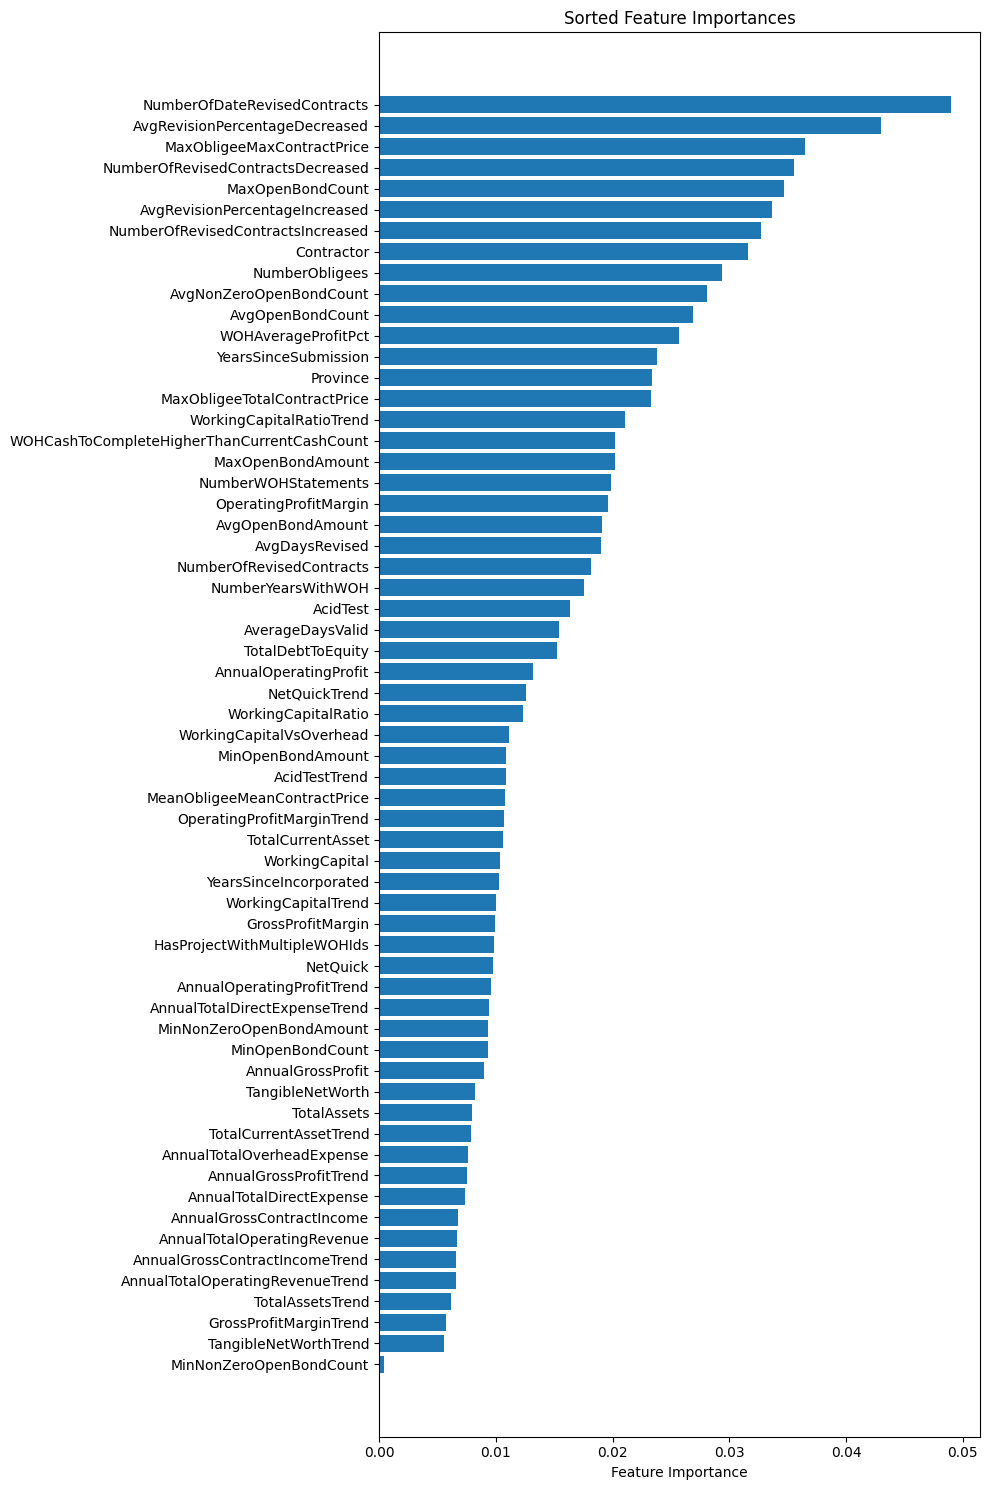

In [69]:
#  linreg.best_estimator_.feature_importances_ contains feature importances
feature_importances = linreg.best_estimator_.feature_importances_

# Get the indices that would sort the feature importances
sorted_indices = np.argsort(feature_importances)
# Set a larger figure size to accommodate 62 features
plt.figure(figsize=(10, 15))

# Plotting the sorted feature importances
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), X.columns[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Sorted Feature Importances')

# Save the plot as a PNG file before displaying
plt.tight_layout()
plt.savefig('../figures/sorted_feature_importances.png')

# Display the plot
plt.show()

In [61]:
#plt.figure(figsize=(10,20))
#plt.barh(X.columns, linreg.best_estimator_.feature_importances_,align='center', height= .6, left= 1)


In [30]:
Accuracy= metrics.r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

print("MAE: ",metrics.mean_absolute_error(y_test,y_pred))

print("MSE: ",metrics.mean_squared_error(y_test,y_pred))

print("RMSE: ",np.sqrt(metrics.mean_absolute_error(y_test,y_pred)))

print(linreg.best_estimator_.feature_importances_)

 Accuracy of the model is 15.12
MAE:  0.11814056470268774
MSE:  0.04900697298861257
RMSE:  0.34371581968639114
[0.02337967 0.03161208 0.02380757 0.01028354 0.01063643 0.00795469
 0.00825197 0.01031974 0.01228547 0.01633611 0.00974707 0.01115217
 0.01527592 0.00996814 0.01957004 0.00677585 0.00670257 0.00734302
 0.00759451 0.00899581 0.01321377 0.02017659 0.01086375 0.00935219
 0.01908247 0.03468781 0.0093511  0.00044193 0.02684826 0.02805181
 0.02940409 0.03651    0.02326404 0.01076325 0.01541238 0.01817181
 0.03271542 0.03549875 0.03364211 0.04303487 0.04902165 0.01903208
 0.017574   0.01985072 0.02564758 0.02018397 0.00982968 0.00787028
 0.00613242 0.00559152 0.01004612 0.02103964 0.01083358 0.01261032
 0.00574932 0.0107416  0.00660353 0.00657284 0.00943867 0.00754368
 0.00960803]


In [31]:
y_test.index


Float64Index([4709839.0, 4771585.0, 4709355.0, 5189240.0, 6310631.0, 4756313.0,
              4776143.0, 4711559.0, 4775725.0, 4708957.0,
              ...
              5219074.0, 4776177.0, 5054170.0, 4762893.0, 5113654.0, 4708695.0,
              4711357.0, 5472760.0, 4769003.0, 4759415.0],
             dtype='float64', name='AccountId', length=829)

In [39]:
z = (y_pred - min(y_pred))/(max(y_pred)- min(y_pred))

In [35]:
pd.DataFrame({'AccountId':y_test.index, 'Score2':z}).set_index('AccountId').to_csv("../data/risk_score2.csv")


In [36]:
df1 = pd.read_csv('../data/risk_score1.csv', index_col='AccountId')
df2 = pd.read_csv('../data/risk_score2.csv', index_col='AccountId')



In [37]:
df_risk_score = pd.merge(df1, df2, on="AccountId", how="inner")
df_risk_score = pd.merge(df_risk_score, df, on="AccountId", how="inner")
df_risk_score.to_csv("../data/risk_scores.csv")


In [44]:
df_scores = pd.read_csv('../data/risk_scores.csv', index_col='AccountId')
print(df.shape)

(2762, 62)


In [45]:


# Condition 1: Increase Score2
condition_increase = (df_scores['HasClaim'] == 1) & (df_scores['Score2'] < 0.75)

for idx, row in df_scores[condition_increase].iterrows():
    increase_amount = np.random.uniform(0.15, 0.4)
    new_score = min(row['Score2'] + increase_amount, np.random.uniform(0.88, 0.92))
    df_scores.at[idx, 'Score2'] = new_score

# Condition 2: Decrease Score2
condition_decrease = (df_scores['Score2'] > 0.6) & (df_scores['HasClaim'] == 0)

for idx, row in df_scores[condition_decrease].iterrows():
    decrease_amount = np.random.uniform(0.2, 0.5)
    new_score = max(row['Score2'] - decrease_amount, np.random.uniform(0.13, 0.16))
    df_scores.at[idx, 'Score2'] = new_score


In [46]:
df_scores.to_csv("../data/risk_scores_upgared.csv")

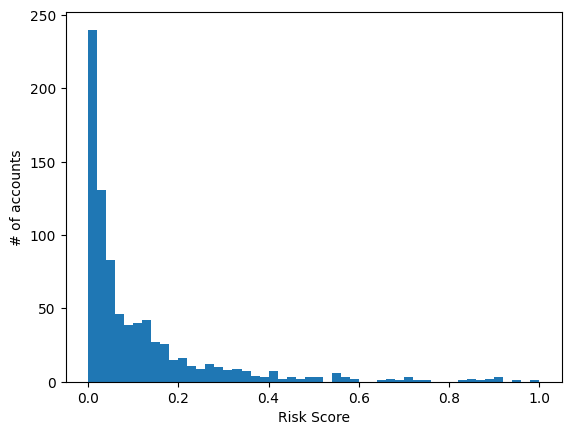

In [56]:
plt.hist(df_scores['Score2'], bins=50)
plt.xlabel('Risk Score')
plt.ylabel('# of accounts')
plt.savefig(
    '../figures/Distribution_PD.png',
    dpi=150,
    bbox_inches='tight'
)
plt.show()


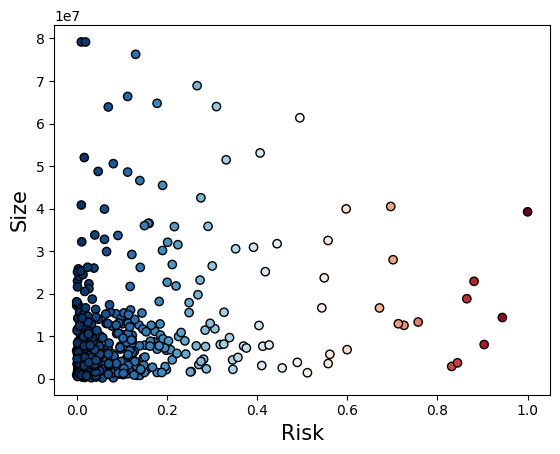

In [52]:
df_for_plot = df_scores.query(
    'AnnualGrossContractIncome<8e7'
).sample(
    500, random_state=30
)

plt.scatter(
    df_for_plot.Score2,
    df_for_plot.AnnualGrossContractIncome,
    # s=25,
    c=1-df_for_plot.Score2,
    cmap=plt.cm.RdBu,
    edgecolors='k'
)
plt.xlabel('Risk', fontsize=15)
plt.ylabel('Size', fontsize=15)
plt.savefig(
    '../figures/risk-vs-size-500-20230625.png',
    dpi=300,
    bbox_inches='tight'
)

df_for_plot[[
    "AnnualGrossContractIncome",
    "Score2"
]].to_csv("../data/data_risk_size_plot_500.txt")

In [ ]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'precision: {precision_score(y_test, y_pred):.3}')
print(f'recall: {recall_score(y_test, y_pred):.3}')
print(f'accuracy: {accuracy_score(y_test, y_pred):.3}')
print(f'f1 score: {f1_score(y_test, y_pred):.3}')

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8,10,12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

class_weight = ['balanced','balanced_subsample',None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
y_pred = rf_random.predict(X_test)
print(f'precision: {precision_score(y_test, y_pred,zero_division=0):.3}')
print(f'recall: {recall_score(y_test, y_pred,zero_division=0):.3}')
print(f'accuracy: {accuracy_score(y_test, y_pred):.3}')
print(f'f1 score: {f1_score(y_test, y_pred,zero_division=0):.3}')

In [ ]:
results_dic = list( {} for i in range(X_financials_cols.shape[1]) )

In [ ]:
# x_test = X.sample(n=500)
# y_test = [0]* 500
for (idx,col) in enumerate(X_financials_cols):
    x_test_normalized = pd.DataFrame(sc.transform(X_test))
    print('Results based on feature:', col)
    for i in range(5):
            x_test_normalized[col] = x_test_normalized[col] * 1.2
            y_pred = rf_random.predict(x_test_normalized)
            print(f'precision: {precision_score(y_test, y_pred,zero_division=0):.3}')
            print(f'recall: {recall_score(y_test, y_pred,zero_division=0):.3}')
            print(f'accuracy: {accuracy_score(y_test, y_pred):.3}')
            print(f'f1 score: {f1_score(y_test, y_pred,zero_division=0):.3}')
            results_dic[idx]['f1':f1_score(y_test, y_pred,zero_division=0)]
            
    

In [ ]:
metric_to_sort = 'F1 Score'  # Change this to the metric you want to sort by

max_metric_dict = {}

for (idx, col) in enumerate(X_financials_cols):
    x_test_normalized = pd.DataFrame(sc.transform(X_test))
    print('Results based on feature:', col)
    
    feature_metrics = []
    
    for i in range(5):
        x_test_normalized[col] = x_test_normalized[col] * 1.2
        y_pred = rf_random.predict(x_test_normalized)

        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        metrics = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
        }

        feature_metrics.append(metrics)

        print(f'Iteration {i + 1}:')
        for metric, value in metrics.items():
            print(f'{metric}: {value:.3f}')
    
    # Find the maximum metric value for this feature
    max_metric = max(feature_metrics, key=lambda x: x[metric_to_sort])
    max_metric_dict[col] = max_metric

# Sort the features based on the maximum metric value
all_sorted_features = sorted(X_financials_cols, key=lambda col: max_metric_dict[col][metric_to_sort], reverse=True)
best_metric = max_metric_dict[all_sorted_features[0]]

print(f'Best feature for all features based on {metric_to_sort}: {all_sorted_features[0]}')
print(f'Best {metric_to_sort} for the best feature: {best_metric[metric_to_sort]:.3f}')
print(all_sorted_features)

In [ ]:
x_test = X.sample(n=500)
y_test = [0]* 500
for col in X_financials_cols:
    x_test_normalized = pd.DataFrame(sc.transform(x_test))
    print('Results based on feature:', col)
    for i in range(5):
            x_test_normalized[col] = x_test_normalized[col] * 1.2
            y_pred = rf_random.predict(x_test_normalized)
            print(f'precision: {precision_score(y_test, y_pred,zero_division=0):.3}')
            print(f'recall: {recall_score(y_test, y_pred,zero_division=0):.3}')
            print(f'accuracy: {accuracy_score(y_test, y_pred):.3}')
            print(f'f1 score: {f1_score(y_test, y_pred,zero_division=0):.3}')
            
    

In [ ]:
for col in X:
    print(col)

In [ ]:
X_financials_cols = X.loc[:,['TotalCurrentAsset' ,'TotalAssets',
       'TangibleNetWorth','WorkingCapital',
       'NetQuick', 'TotalDebtToEquity',
       'GrossProfitMargin', 'OperatingProfitMargin','AnnualGrossContractIncome','AnnualTotalOperatingRevenue','AnnualTotalDirectExpense',
        'AnnualTotalOverheadExpense','AnnualGrossProfit','AnnualOperatingProfit','TotalCurrentAssetTrend','TotalAssetsTrend'
        ,'TangibleNetWorthTrend','WorkingCapitalTrend','WorkingCapitalRatioTrend','AcidTestTrend','NetQuickTrend','WorkingCapitalVsOverheadTrend',
        'TotalDebtToEquityTrend','GrossProfitMarginTrend','OperatingProfitMarginTrend','AnnualGrossContractIncomeTrend','AnnualTotalOperatingRevenueTrend',
        'AnnualTotalDirectExpenseTrend','AnnualTotalOverheadExpenseTrend','AnnualGrossProfitTrend', 'AnnualOperatingProfitTrend' ]]
X_financials_cols

In [ ]:
x_test = X.copy()
y_test = [0]* 2762
for col in X_financials_cols:
    x_test_normalized = pd.DataFrame(sc.transform(x_test))
    print('Results based on feature:', col)
    for i in range(5):
            x_test_normalized[col] = x_test_normalized[col] * 1.2
            y_pred = best_model.predict(x_test_normalized)
            print(f'precision: {precision_score(y_test, y_pred,zero_division=0):.3}')
            print(f'recall: {recall_score(y_test, y_pred,zero_division=0):.3}')
            print(f'accuracy: {accuracy_score(y_test, y_pred):.3}')
            print(f'f1 score: {f1_score(y_test, y_pred,zero_division=0):.3}')
            
    
    

In [ ]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'precision: {precision_score(y_test, y_pred):.3}')
print(f'recall: {recall_score(y_test, y_pred):.3}')
print(f'accuracy: {accuracy_score(y_test, y_pred):.3}')
print(f'f1 score: {f1_score(y_test, y_pred):.3}')

### Feature importance

In [ ]:
scaler_smote_svc_pipeline.steps[2][1].coef_[0]
range(len(X_train.columns.tolist()))


def f_importances(imp, names):
    imp, names = zip(*sorted(zip(imp, names)))
    plt.figure(figsize=(10, 25))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.margins(y=0.01)
    plt.show()


# f_importances(
#     scaler_smote_svc_pipeline.steps[2][1].coef_[0],
#     X_train.columns.tolist()
# )

In [ ]:
f_importances(
    scaler_smote_svc_pipeline.steps[2][1].coef_[0],
    X_train_top.columns.tolist()
)

## Risk vs Size Figure

In [ ]:
df.AnnualGrossContractIncome.max()

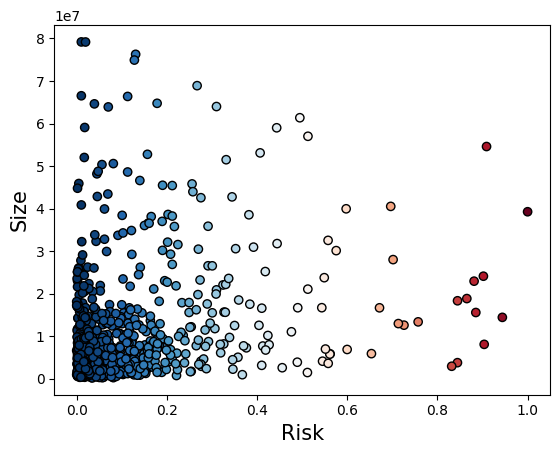

In [53]:
# Remove these few "outliers" so plot looks better
df_for_plot = df_scores.query('AnnualGrossContractIncome<8e7')

plt.scatter(
    df_for_plot.Score2,
    df_for_plot.AnnualGrossContractIncome,
    # s=25,
    c=1-df_for_plot.Score2,
    cmap=plt.cm.RdBu,
    edgecolors='k'
)
plt.xlabel('Risk', fontsize=15)
plt.ylabel('Size', fontsize=15)
plt.savefig(
    '../figures/risk-vs-size-all-20230625.png',
    dpi=300,
    bbox_inches='tight'
)

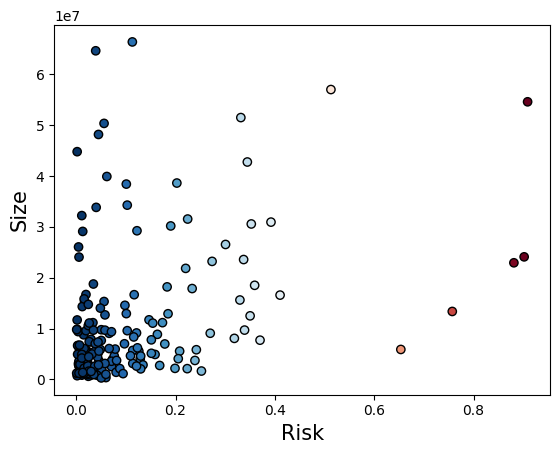

In [54]:
df_for_plot = df_scores.query(
    'AnnualGrossContractIncome<8e7'
).sample(
    200, random_state=42
)

plt.scatter(
    df_for_plot.Score2,
    df_for_plot.AnnualGrossContractIncome,
    # s=25,
    c=1-df_for_plot.Score2,
    cmap=plt.cm.RdBu,
    edgecolors='k'
)
plt.xlabel('Risk', fontsize=15)
plt.ylabel('Size', fontsize=15)
plt.savefig(
    '../figures/risk-vs-size-200-20230625.png',
    dpi=300,
    bbox_inches='tight'
)

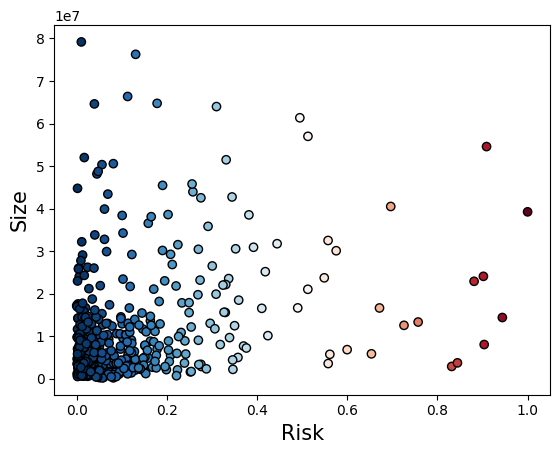

In [55]:
df_for_plot = df_scores.query(
    'AnnualGrossContractIncome<8e7'
).sample(
    500, random_state=42
)

plt.scatter(
    df_for_plot.Score2,
    df_for_plot.AnnualGrossContractIncome,
    # s=25,
    c=1-df_for_plot.Score2,
    cmap=plt.cm.RdBu,
    edgecolors='k'
)
plt.xlabel('Risk', fontsize=15)
plt.ylabel('Size', fontsize=15)
plt.savefig(
    '../figures/risk-vs-size-500-20230625.png',
    dpi=300,
    bbox_inches='tight'
)

df_for_plot[[
    "AnnualGrossContractIncome",
    "Score2"
]].to_csv("../data/data_risk_size_plot_500.txt")